# Convolutional autoencoders

In this script we write a CNN autoencoder and apply it to the task of image desnoising.

<center><a href="https://en.wikipedia.org/wiki/Total_variation_denoising">
    <img src="https://upload.wikimedia.org/wikipedia/commons/e/e8/ROF_Denoising_Example.png"></a></center>


In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt
import copy

In [2]:
# Initialization function for the network's parameters
def init_params(m, seed=0):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, mean=1, std=0.02, generator=torch.manual_seed(seed))
        m.bias.data.fill_(0.01)
    return

# Plot function
def myplot(x):
    plt.figure()
    plt.imshow(x.detach().squeeze().numpy(), cmap='gray')
    plt.show()
    return

## Transposed convolution

As seen in the previous lab, convolution usually reduces the size of the image (except if we compensate using padding). However, in some applications (e.g., image synthesis from low-dimension features) it is usefull to increase it. That's notably needed for autoencoders, since after projecting the data into a compact latent representation, we need to expand this representation back into the image space.

This is exactly what [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html#torch.nn.ConvTranspose2d) does. Simply put, a transposed convolution adds some zeros inside the input image (and on the edge) to artificially increase the size.

Convolution             |  Transposed convolution
:-------------------------:|:-------------------------:
![](https://miro.medium.com/max/294/1*BMngs93_rm2_BpJFH2mS0Q.gif)  |  ![](https://miro.medium.com/max/395/1*Lpn4nag_KRMfGkx1k6bV-g.gif)


On the left, we use convolution with a kernel size of 3 and stride of 2. On the right, we then use a transposed convolution with the same parameters, and its effect is to procude an image with the same size as the original.

torch.Size([1, 1, 343, 550])


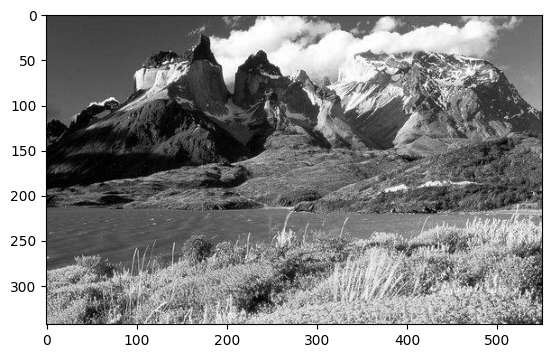

In [3]:
# Load the provided example image, and convert it in black and white
image_t = torchvision.io.read_image('tdp.jpeg', mode=torchvision.io.ImageReadMode.RGB)
image_t = torchvision.transforms.functional.rgb_to_grayscale(image_t)

# Convert as a float tensor, normalize it so the values range in [0, 1], and expand to a batch
image_t = image_t.float()
image_t /= image_t.max()
image_t = image_t.unsqueeze(0)

# Print the shape and plot it
print(image_t.shape)
myplot(image_t)

Original image:  torch.Size([1, 1, 343, 550])
Output of the convolution :  torch.Size([1, 1, 86, 137])


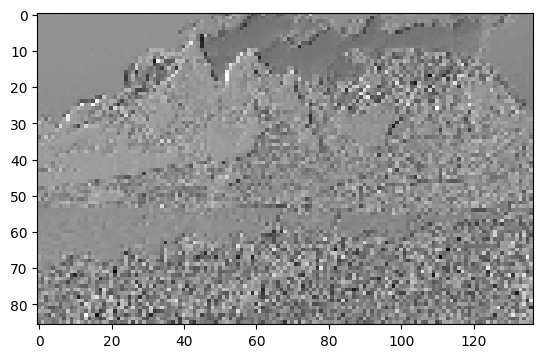

In [4]:
num_channels_in = 1
num_channels_out = 1

# First, let us apply a convolution with a kernel size of (3, 6) and a stride of 4.
my_conv = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=(3, 6), stride=4)
output = my_conv(image_t)
print('Original image: ', image_t.shape)
print('Output of the convolution : ', output.shape)

# Display the output after convolution
myplot(output)

After applying transposed convolution :  torch.Size([1, 1, 343, 550])


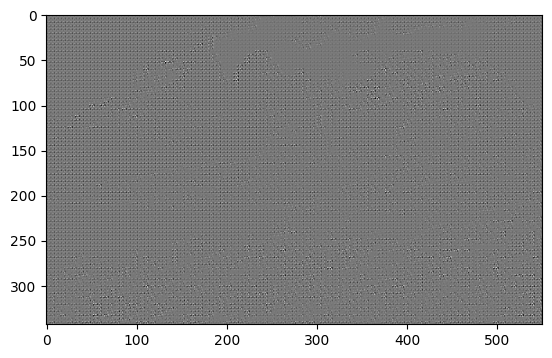

In [5]:
# Now we reproduce an image with the same size as the original input
my_convt = nn.ConvTranspose2d(num_channels_in, num_channels_out, kernel_size=(3, 6), stride=4)
image_convt = my_convt(output)
print('After applying transposed convolution : ', image_convt.shape)

# Display the output after transposed convolution
myplot(image_convt)

As you can see, transposed convolution does not invert convolution (it's not "deconvolution"): it only guarantees that the size will be equal to that of the image before convolution (but not its pixel values).

## Dataset

In [6]:
# Dataset repository - remember to change it according to your folder structure
data_dir = '../datasets/'

# Load the MNIST dataset
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))])
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=data_transforms)
test_data = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=data_transforms)
num_classes = len(train_data.classes)

# Take a subset of the train/test data
train_data = Subset(train_data, torch.arange(500))
test_data = Subset(train_data, torch.arange(50))

# We define the train and validation sets and dataloaders as in the previous script
n_train_examples = int(len(train_data)*0.8)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = random_split(train_data, [n_train_examples, n_valid_examples], generator=torch.manual_seed(0))

# Create the dataloaders
batch_size = 8
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(0))
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

## CNN autoencoder

As seen in lab 4, autoencoders are networks that project the input data into a low-dimension space, and then expand this compact representation back into the input space. In CNN autoencoders, the encoder uses convolutions to reduce the image size, while the decoder uses transposed convolutions to expand it. We propose the following architecture:

- The encoder consists of two layers, with a convolution function, a RELU and a max pooling. The convolution functions have a kernel size of 3 and a padding of 1. They use 16 and 4 output channels, respectively. The max pooling functions use a kernel size of 2.

- The decoder consists of two layers, with a transposed convolution and an activation function (RELU for the first layer, Sigmoid for the second layer). The transposed convolution functions have a kernel size of 2 and a stride of 2. They use 16 and 1 output channels, respectively.

In [7]:
# TO DO: write the CNN autoencoder module ('__init__' and 'forward' methods)
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        x = self.conv1(x)
        encoder_out = self.conv2(x)
        return encoder_out
    

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(4, 16, kernel_size=2, stride=2),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        decoder_out = self.conv2(x)
        return decoder_out

In [8]:
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        y = self.decoder(x)
        return y

In [9]:
# Instantiate the CNN autoencoder, initialize it, and print the number of parameters
model_cnn_ae = CNNAutoencoder()
model_cnn_ae.apply(init_params)
print('Total number of parameters:', sum(p.numel() for p in model_cnn_ae.parameters()))

Total number of parameters: 1077


In [10]:
# Before training, make sure that the output of the autoencoder has the same shape as its input.
# If that's not the case, there's something to debug somewhere.
image_batch_example = next(iter(train_dataloader))[0]
out = model_cnn_ae(image_batch_example)
print(image_batch_example.shape)
print(out.shape)

torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])


In [11]:
import numpy as np
def evaluation(model, eval_dataloader, loss_fn):

    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval()

     # Initialize a list with the loss for batches
    losses = []

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():

        # Iterate over the dataset using the dataloader
        for images, _ in eval_dataloader:

            # Get the predicted labels
            images_predicted = model(images)

            # Get the loss
            loss = loss_fn(images_predicted,images)
            losses.append(loss.item())

    accuracy = np.mean(losses)

    return accuracy

In [12]:
# TO DO: write the autoencoder training function with validation (also write the evaluation function)
# It's similar to the MLP autoencoder (lab 4.2), but images don't need to be vectorized
def training(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed)
    model_tr.train()
    
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    

    train_losses = []
    accuracy = []
    
    # Training loop
    for epoch in range(num_epochs):
        tr_loss = 0
        
        for batch_index, (images, labels) in enumerate(train_dataloader):

            # forward pass
            y = model_tr(images)
            loss = loss_fn(y, images)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update the current epoch loss
            tr_loss += loss.item() * images.shape[0]

        # At the end of each epoch, get the average training loss and store it
        tr_loss = tr_loss/len(train_dataloader.dataset)
        train_losses.append(tr_loss)

        valid_acc = evaluation(model_tr, valid_dataloader, loss_fn)
        accuracy.append(valid_acc)

        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, num_epochs, loss, valid_acc))

        
    return model_tr, train_losses, accuracy


<span style="color:red">**Exercice 3**</span> Using the training parameters below, train the model and plot the training and validation losses on the same plot.

In [13]:
# Training parameters
num_epochs = 50
loss_fn = nn.MSELoss()
learning_rate = 0.001

In [14]:
model, loss, acc = training(model_cnn_ae, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate)

Epoch [1/50], Training loss: 1.0277, Accuracy: 1.1215
Epoch [2/50], Training loss: 0.6243, Accuracy: 0.6941
Epoch [3/50], Training loss: 0.5991, Accuracy: 0.6240
Epoch [4/50], Training loss: 0.5372, Accuracy: 0.6012
Epoch [5/50], Training loss: 0.5651, Accuracy: 0.5832
Epoch [6/50], Training loss: 0.5644, Accuracy: 0.5682
Epoch [7/50], Training loss: 0.5491, Accuracy: 0.5591
Epoch [8/50], Training loss: 0.5359, Accuracy: 0.5530
Epoch [9/50], Training loss: 0.4111, Accuracy: 0.5484
Epoch [10/50], Training loss: 0.4948, Accuracy: 0.5448
Epoch [11/50], Training loss: 0.5393, Accuracy: 0.5414
Epoch [12/50], Training loss: 0.5635, Accuracy: 0.5390
Epoch [13/50], Training loss: 0.5229, Accuracy: 0.5363
Epoch [14/50], Training loss: 0.5348, Accuracy: 0.5345
Epoch [15/50], Training loss: 0.5662, Accuracy: 0.5332
Epoch [16/50], Training loss: 0.5262, Accuracy: 0.5318
Epoch [17/50], Training loss: 0.5238, Accuracy: 0.5306
Epoch [18/50], Training loss: 0.5338, Accuracy: 0.5298
Epoch [19/50], Trai

Text(0, 0.5, 'Loss')

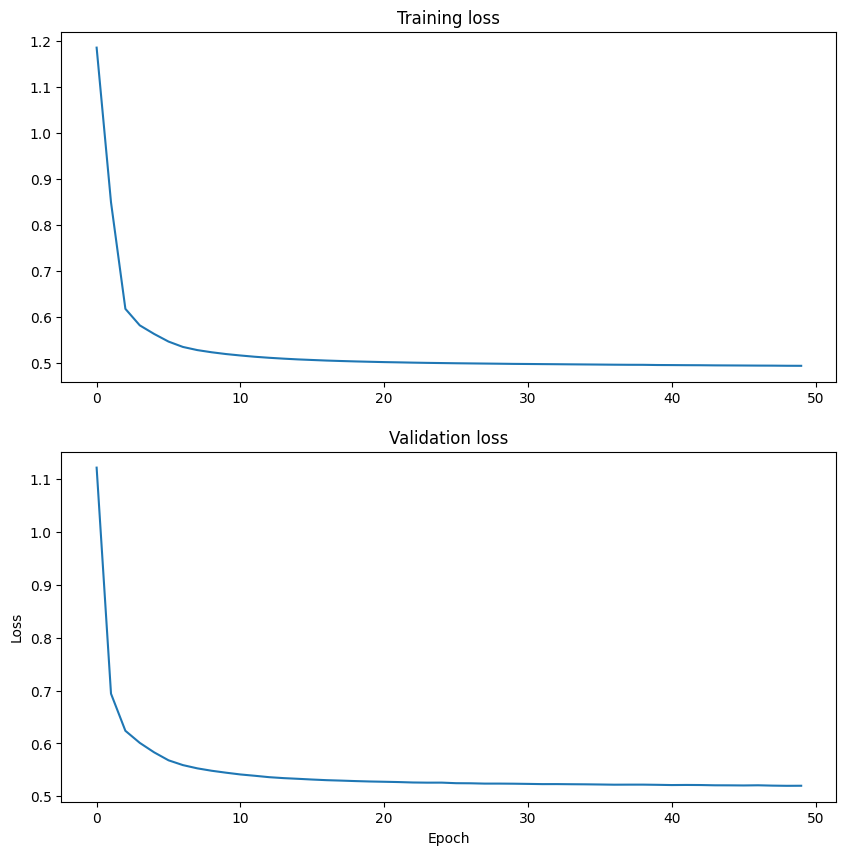

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.plot(loss)
ax1.set_title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax2.plot(acc)
ax2.set_title('Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

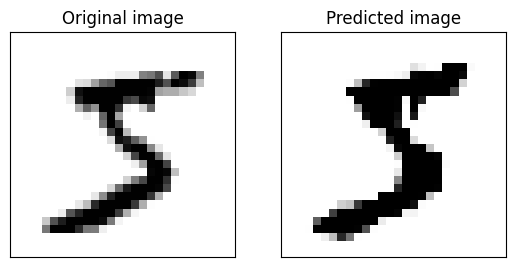

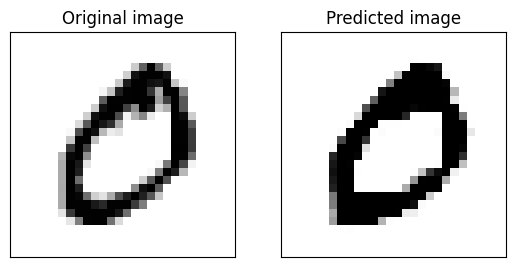

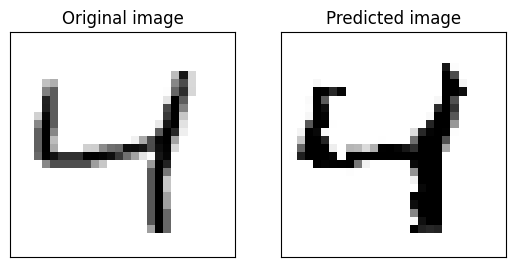

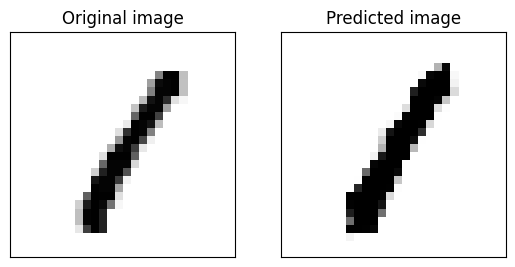

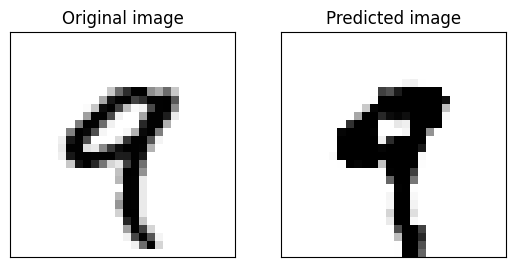

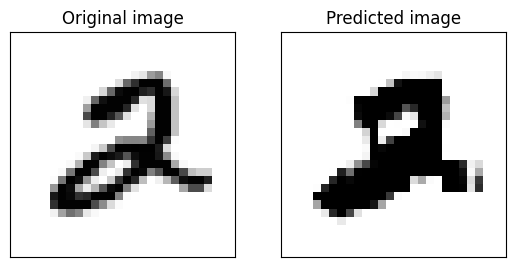

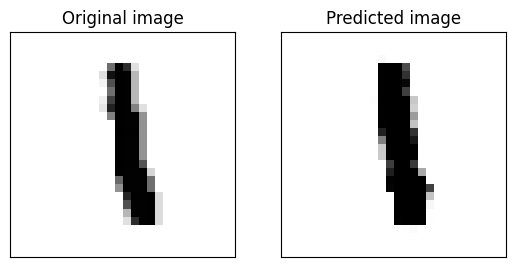

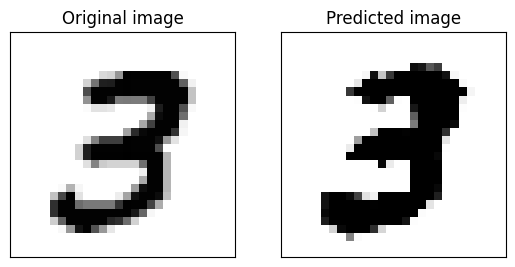

In [16]:
# Vizualization

# Get an example batch from the test set
test_batch_example = next(iter(test_dataloader))[0]

# Pass it to the autoencoder 
with torch.no_grad():
    test_batch_example_pred = model(test_batch_example)

# Plot the original and predicted images
for ib in range(batch_size):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(test_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Original image')
    plt.subplot(1, 2, 2)
    plt.imshow(test_batch_example_pred[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Predicted image')
    plt.show()

## Denoising autoencoder

We now consider an application of autoencoders, which is image denoising. We use the same CNN autoencoder model as above, but the thing that changes is the data on which it is trained. Indeed, the denoising autoencoder takes as inputs the noisy images, and outputs clean (denoised) imaged. However, we don't need to create a new dataset with noisy images: we simply need to add noise to the images during training before passing them to the model.

<center><a href="https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798">
    <img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*SxwRp9i23OM0Up4sEze1QQ@2x.png" width="550"></a></center>


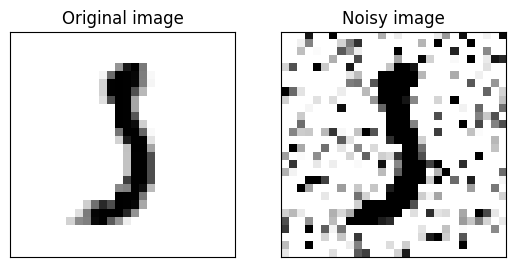

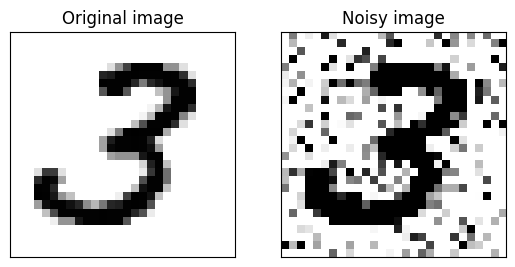

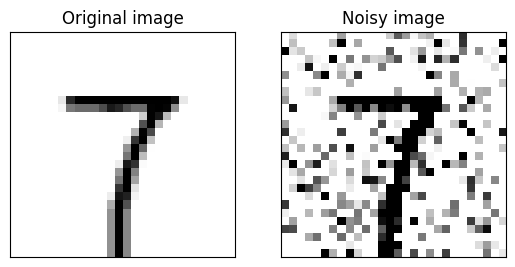

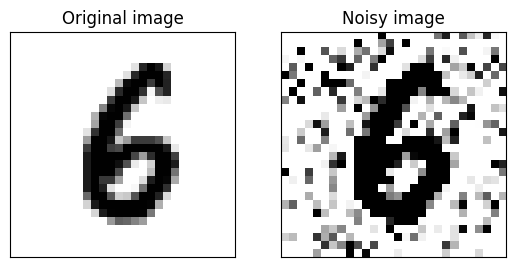

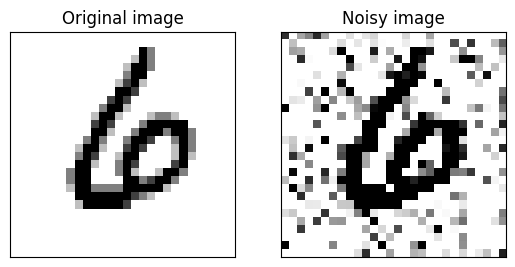

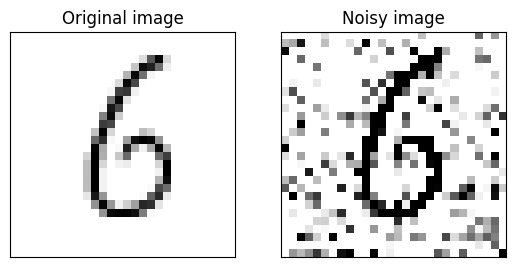

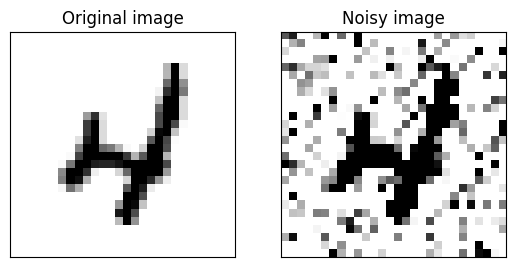

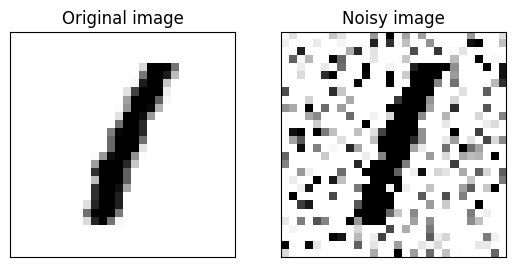

In [17]:
# First, here is a function that adds some noise to an input image batch
def add_noise(inputs,noise_factor=0.8):
     noisy = inputs+torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy,0.,1.)
     return noisy

# Add noise to the image_batch_example
noisy_images_batch = add_noise(image_batch_example)

# Plot the original and noisy images
for ib in range(batch_size):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Original image')
    plt.subplot(1, 2, 2)
    plt.imshow(noisy_images_batch[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Noisy image')
    plt.show()

The training function is the same as before, except that we need to add the noise to the images before passing them to the model. Then, we compute the loss between the original images (clean) and the output of the model (denoised).

In [18]:
# TO DO: write the training function (with validation) for the denoising autoencoder
# TO DO: write the autoencoder training function with validation (also write the evaluation function)
# It's similar to the MLP autoencoder (lab 4.2), but images don't need to be vectorized
def training(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed)
    model_tr.train()
    
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    

    train_losses = []
    accuracy = []
    
    # Training loop
    for epoch in range(num_epochs):
        tr_loss = 0
        
        for batch_index, (images, labels) in enumerate(train_dataloader):

            # input noise
            noisy_images = add_noise(images)

            # forward pass
            y = model_tr(noisy_images)
            loss = loss_fn(y, images)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update the current epoch loss
            tr_loss += loss.item() * images.shape[0]

        # At the end of each epoch, get the average training loss and store it
        tr_loss = tr_loss/len(train_dataloader.dataset)
        train_losses.append(tr_loss)

        valid_acc = evaluation(model_tr, valid_dataloader, loss_fn)
        accuracy.append(valid_acc)

        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, num_epochs, loss, valid_acc))

        
    return model_tr, train_losses, accuracy



<span style="color:red">**Exercice 4**</span> Instanciate a CNN autoencoder and initialize its parameters. Using the same training parameters as above, train the model for the denoising task. After training, plot the training and validation losses over epochs (on the same plot).

In [19]:
model_den, loss_den, acc_den = training(model_cnn_ae, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate)

Epoch [1/50], Training loss: 1.0707, Accuracy: 1.2368
Epoch [2/50], Training loss: 0.8819, Accuracy: 0.9815
Epoch [3/50], Training loss: 0.8171, Accuracy: 0.7419
Epoch [4/50], Training loss: 0.6835, Accuracy: 0.6985
Epoch [5/50], Training loss: 0.6015, Accuracy: 0.6856
Epoch [6/50], Training loss: 0.6494, Accuracy: 0.6787
Epoch [7/50], Training loss: 0.6672, Accuracy: 0.6738
Epoch [8/50], Training loss: 0.6701, Accuracy: 0.6665
Epoch [9/50], Training loss: 0.6908, Accuracy: 0.6569
Epoch [10/50], Training loss: 0.5727, Accuracy: 0.6452
Epoch [11/50], Training loss: 0.6003, Accuracy: 0.6304
Epoch [12/50], Training loss: 0.6288, Accuracy: 0.6207
Epoch [13/50], Training loss: 0.5551, Accuracy: 0.6123
Epoch [14/50], Training loss: 0.4939, Accuracy: 0.6067
Epoch [15/50], Training loss: 0.6451, Accuracy: 0.6004
Epoch [16/50], Training loss: 0.5897, Accuracy: 0.5945
Epoch [17/50], Training loss: 0.5459, Accuracy: 0.5890
Epoch [18/50], Training loss: 0.5621, Accuracy: 0.5803
Epoch [19/50], Trai

Text(0, 0.5, 'Loss')

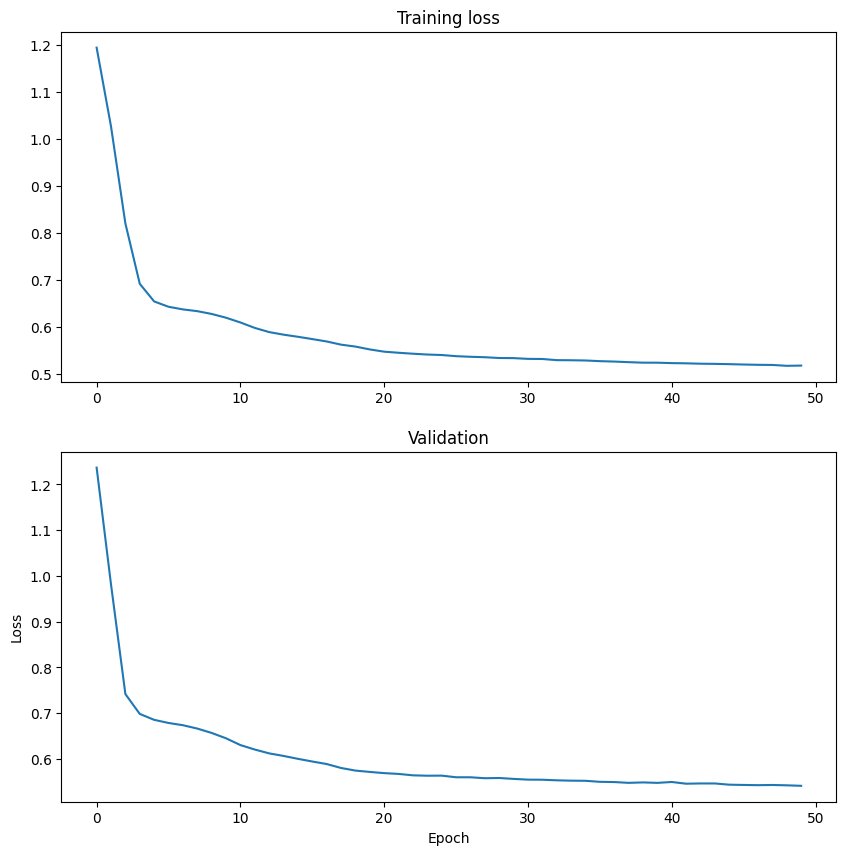

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.plot(loss_den)
ax1.set_title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax2.plot(acc_den)
ax2.set_title('Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')

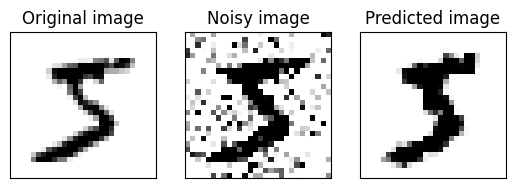

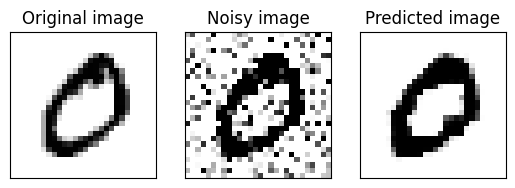

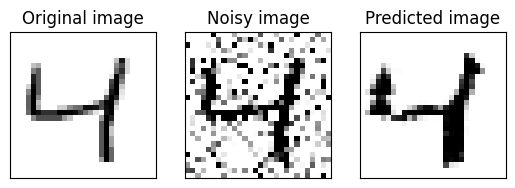

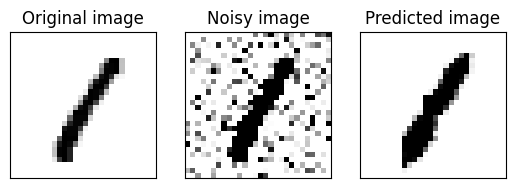

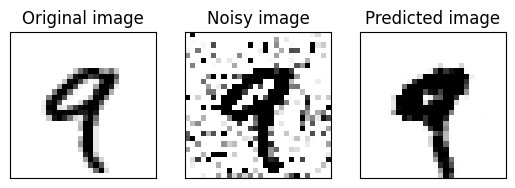

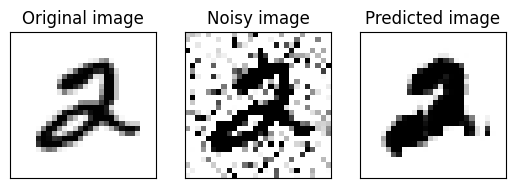

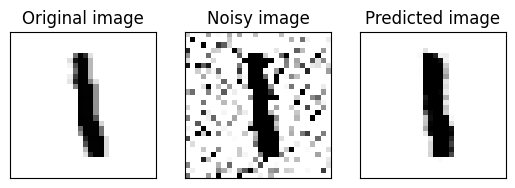

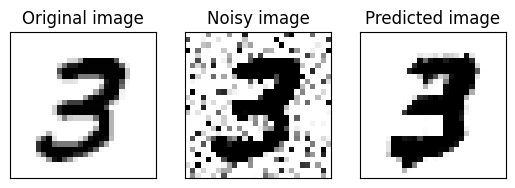

In [21]:
# Vizualization

# Add noise to the test batch
test_batch_example_noisy = add_noise(test_batch_example)

# Pass the noisy images to the autoencoder 
with torch.no_grad():
    test_batch_example_den = model_den(test_batch_example_noisy)

# Plot the original and predicted images
for ib in range(batch_size):
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(test_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Original image')
    plt.subplot(1, 3, 2)
    plt.imshow(test_batch_example_noisy[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Noisy image')
    plt.subplot(1, 3, 3)
    plt.imshow(test_batch_example_den[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Predicted image')
    plt.show()